In [99]:
import gym
import gym_foa
from gym import wrappers

ENV_NAME = 'foa-v0'
env = gym.make(ENV_NAME)


import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import namedtuple
import random
import matplotlib.pyplot as plt
import copy
import time
import os

[2017-10-02 11:21:51,529] Making new env: foa-v0
[2017-10-02 11:21:51,717] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/linjt/foa/total_cost')


In [100]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
env = wrappers.Monitor(env, 'all_epi_total_cost', force=True, video_callable=lambda episode_id: True)
TAU = .01
GAMMA = .9
LR_actor = .001
LR_critic = .001
EXPERIENCE_CAPACITY = 7000
TARGET_UPDATE_FREQUENCY = 200
MAX_EPI = 3*int(1e4)
MAX_STEP = 100
BATCH_SIZE = 32
#EPSILON = .1
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.shape[0]
N_UAVS = 1

[2017-10-02 11:22:53,055] Creating monitor directory all_epi_total_cost


In [101]:
# initialization
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

In [102]:
# classes
class Experience(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.mem = []
        self.pos = 0
    
    def push(self, o, a, r, o_next):
        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = Transition(o, a, r, o_next)
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, size):
        return random.sample(self.mem, min(size, len(self.mem)))
        #return self.mem[:1]
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fcS = nn.Linear(N_STATES, 150)
        self.fcS.weight.data.normal_(0, 0.1)
        self.fcA = nn.Linear(N_ACTIONS, 150)
        self.fcA.weight.data.normal_(0, 0.1)
        self.fc1 = nn.Linear(150, 100)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(100, 100)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(100, 1)
        self.fc3.weight.data.normal_(0, 0.1)
    
    def forward(self, x, y):
        s = self.fcS(x)
        a = self.fcA(y)
        o = F.relu(s+a)
        o = self.fc1(o)
        o = F.relu(o)
        o = self.fc2(o)
        o = F.relu(o)
        o = self.fc3(o)
        return o

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(N_STATES/N_UAVS, 150)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(150, 100)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(100, 100)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4 = nn.Linear(100, N_ACTIONS/N_UAVS)
        self.fc4.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [103]:
def choose_action(state, actor):
    a = actor(Variable(Tensor(state).unsqueeze(0))).data.cpu().numpy()[0].astype('float64')
    return a

def update_actor_critic(target_actor, target_critic, \
                       actor, critic, exp, optim_actor, optim_critic):
    
    
    
    # sample minibatch
    minibatch = Transition(*zip(*exp.sample(BATCH_SIZE)))
    bat_o = Variable(Tensor(minibatch.state))
    bat_a = Variable(Tensor(minibatch.action))
    bat_r = Variable(Tensor(minibatch.reward)).unsqueeze(1)
    bat_o_ = Variable(Tensor(minibatch.next_state))
    
    bat_a0_ = target_actor(bat_o_[:,:N_STATES/N_UAVS])
    #bat_a1_ = target_actor(bat_o_[:,N_STATES/N_UAVS:-N_STATES/N_UAVS])
    #bat_a2_ = target_actor(bat_o_[:,-N_STATES/N_UAVS:])
    #bat_a_o_ = torch.cat([bat_a0_, bat_a1_, bat_a2_], dim=1)
    bat_a_o_ = bat_a0_

    Gt = bat_r + GAMMA * target_critic(bat_o_, bat_a_o_)
    Gt.detach_()
    eval_o = critic(bat_o, bat_a)
    criterion = nn.MSELoss()
    if use_cuda:
        criterion.cuda()
    loss = criterion(eval_o, Gt)
    #optimizer = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_critic.zero_grad()
    loss.backward()
    optim_critic.step()
    
    # update actor
    bat_a0 = actor(bat_o[:,:N_STATES/N_UAVS])
    #bat_a1 = actor(bat_o[:,N_STATES/N_UAVS:-N_STATES/N_UAVS])
    #bat_a2 = actor(bat_o[:,-N_STATES/N_UAVS:])
    #bat_a_o = torch.cat([bat_a0, bat_a1, bat_a2], dim=1)
    bat_a_o = bat_a0
    
    obj = torch.mean(critic(bat_o, bat_a_o))
    #optimizer = optim.Adam(actor.parameters(), lr=-LR_actor)
    optim_actor.zero_grad()
    obj.backward()
    optim_actor.step()    

def update_target(target_actor, target_critic, \
                         actor, critic):
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

def soft_update(target, behavior, tau):
    for key in target.state_dict().keys():
        target.state_dict()[key].copy_(tau * behavior.state_dict()[key] + (1-tau) * target.state_dict()[key])

In [ ]:
start_time = time.time()

n_vec_r = []
n_vec_avg_cost = []
n_vec_total_cost = []
for n in xrange(1):    
    target_actor = Actor()
    target_critic = Critic()
    actor = Actor()
    critic = Critic()
    if use_cuda:
        target_actor.cuda()
        target_critic.cuda()
        actor.cuda()
        critic.cuda()
    exp = Experience(EXPERIENCE_CAPACITY)
    optim_critic = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_actor = optim.Adam(actor.parameters(), lr=-LR_actor)

    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())
    
    vec_r = []
    vec_avg_cost = []
    vec_total_cost = []
    update_counter = 0
    for epi in xrange(MAX_EPI):
        if epi%(MAX_EPI/50)==0:
            print 'n:{}, epi:{}'.format(n, epi)
            
        o = env.reset()
        acc_r = 0
        
        local_r = []
        
        avg_cost = np.zeros([4])
        total_cost = 0
    
        counter = 0
        #for t in xrange(MAX_STEP):    
        while True:
            counter += 1
            
            env.render()
            
            a0 = choose_action(o[:N_STATES/N_UAVS], actor)
            #a1 = choose_action(o[N_STATES/N_UAVS:-N_STATES/N_UAVS], actor)
            #a2 = choose_action(o[-N_STATES/N_UAVS:], actor)
            #a = np.hstack([a0, a1, a2])
            a = a0
            #print a
            #a = np.array([0,1,0,1,0,1])
            
            o_, r, done, info = env.step(a)
            exp.push(o, a, r, o_)
            
            cost = np.array(info['cost'])
            avg_cost += (cost-avg_cost)/(counter)
            total_cost += r
            #print cost
            #print o
            #print avg_cost
            
            #torch.cuda.synchronize()
            #start_time = time.time()
            
            update_actor_critic(target_actor, target_critic, \
                               actor, critic, exp, optim_actor, optim_critic)
            update_counter += 1
            
            #torch.cuda.synchronize()
            #print("--- %s seconds ---" % (time.time() - start_time))  
            
            if update_counter % TARGET_UPDATE_FREQUENCY == 0:
                update_target(target_actor, target_critic, \
                             actor, critic)
            
            local_r.append(r)
            acc_r += r
            o = o_
            if done:
                break
        
        #print counter

#         if epi % (MAX_EPI/10) == (MAX_EPI/10)-1:
#             plt.plot(xrange(len(local_r)), local_r)
#             plt.title('n: {}, epi: {}'.format(n, epi))
#             plt.show()
    
        vec_r.append(acc_r)
        vec_avg_cost.append(avg_cost)
        vec_total_cost.append(total_cost)
        
    n_vec_r.append(vec_r)
    n_vec_avg_cost.append(vec_avg_cost)
    n_vec_total_cost.append(vec_total_cost)
    torch.save(actor.state_dict(), 'actor{}.pt'.format(n))

print("--- %s seconds ---" % (time.time() - start_time))



[2017-10-02 11:23:13,308] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000000.mp4


n:0, epi:0


[2017-10-02 11:23:13,908] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000001.mp4
[2017-10-02 11:23:14,294] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000002.mp4
[2017-10-02 11:23:14,665] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000003.mp4
[2017-10-02 11:23:15,049] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000004.mp4
[2017-10-02 11:23:15,421] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000005.mp4
[2017-10-02 11:23:15,829] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000006.mp4
[2017-10-02 11:23:16,221] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000007.mp4
[2017-10-02 11:23:16

[2017-10-02 11:23:58,526] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000060.mp4
[2017-10-02 11:24:42,426] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000061.mp4
[2017-10-02 11:24:42,685] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000062.mp4
[2017-10-02 11:24:42,961] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000063.mp4
[2017-10-02 11:24:43,259] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000064.mp4
[2017-10-02 11:24:43,549] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000065.mp4
[2017-10-02 11:24:43,862] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000066.mp4
[2017-10-02 11:24:44

[2017-10-02 11:25:02,701] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000119.mp4
[2017-10-02 11:25:03,108] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000120.mp4
[2017-10-02 11:25:03,544] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000121.mp4
[2017-10-02 11:25:03,925] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000122.mp4
[2017-10-02 11:25:04,292] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000123.mp4
[2017-10-02 11:25:04,671] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000124.mp4
[2017-10-02 11:25:05,012] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000125.mp4
[2017-10-02 11:25:05

[2017-10-02 11:25:26,112] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000178.mp4
[2017-10-02 11:25:26,526] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000179.mp4
[2017-10-02 11:25:26,979] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000180.mp4
[2017-10-02 11:25:27,358] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000181.mp4
[2017-10-02 11:25:27,817] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000182.mp4
[2017-10-02 11:25:28,229] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000183.mp4
[2017-10-02 11:25:28,653] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000184.mp4
[2017-10-02 11:25:29

[2017-10-02 11:25:50,147] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000237.mp4
[2017-10-02 11:25:50,565] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000238.mp4
[2017-10-02 11:25:50,986] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000239.mp4
[2017-10-02 11:25:51,417] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000240.mp4
[2017-10-02 11:25:51,812] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000241.mp4
[2017-10-02 11:25:52,192] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000242.mp4
[2017-10-02 11:25:52,553] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000243.mp4
[2017-10-02 11:25:52

[2017-10-02 11:26:14,026] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000296.mp4
[2017-10-02 11:26:14,462] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000297.mp4
[2017-10-02 11:26:14,902] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000298.mp4
[2017-10-02 11:26:15,308] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000299.mp4
[2017-10-02 11:26:15,769] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000300.mp4
[2017-10-02 11:26:16,165] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000301.mp4
[2017-10-02 11:26:16,592] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000302.mp4
[2017-10-02 11:26:16

[2017-10-02 11:26:38,074] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000355.mp4
[2017-10-02 11:26:38,476] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000356.mp4
[2017-10-02 11:26:38,901] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000357.mp4
[2017-10-02 11:26:39,264] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000358.mp4
[2017-10-02 11:26:39,749] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000359.mp4
[2017-10-02 11:26:40,139] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000360.mp4
[2017-10-02 11:26:40,508] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000361.mp4
[2017-10-02 11:26:40

[2017-10-02 11:27:02,221] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000414.mp4
[2017-10-02 11:27:02,650] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000415.mp4
[2017-10-02 11:27:03,064] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000416.mp4
[2017-10-02 11:27:03,474] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000417.mp4
[2017-10-02 11:27:03,877] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000418.mp4
[2017-10-02 11:27:04,298] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000419.mp4
[2017-10-02 11:27:04,652] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000420.mp4
[2017-10-02 11:27:05

[2017-10-02 11:27:25,849] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000473.mp4
[2017-10-02 11:27:26,265] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000474.mp4
[2017-10-02 11:27:26,627] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000475.mp4
[2017-10-02 11:27:26,985] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000476.mp4
[2017-10-02 11:27:27,396] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000477.mp4
[2017-10-02 11:27:27,810] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000478.mp4
[2017-10-02 11:27:28,165] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000479.mp4
[2017-10-02 11:27:28

[2017-10-02 11:27:49,342] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000532.mp4
[2017-10-02 11:27:49,760] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000533.mp4
[2017-10-02 11:27:50,115] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000534.mp4
[2017-10-02 11:27:50,502] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000535.mp4
[2017-10-02 11:27:50,859] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000536.mp4
[2017-10-02 11:27:51,226] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000537.mp4
[2017-10-02 11:27:51,633] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000538.mp4
[2017-10-02 11:27:52

[2017-10-02 11:28:12,925] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000591.mp4
[2017-10-02 11:28:13,241] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000592.mp4
[2017-10-02 11:28:13,563] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000593.mp4
[2017-10-02 11:28:13,904] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000594.mp4
[2017-10-02 11:28:14,248] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000595.mp4
[2017-10-02 11:28:14,572] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000596.mp4
[2017-10-02 11:28:14,923] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000597.mp4
[2017-10-02 11:28:15

n:0, epi:600


[2017-10-02 11:28:16,266] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000601.mp4
[2017-10-02 11:28:16,603] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000602.mp4
[2017-10-02 11:28:16,950] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000603.mp4
[2017-10-02 11:28:17,291] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000604.mp4
[2017-10-02 11:28:17,669] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000605.mp4
[2017-10-02 11:28:18,023] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000606.mp4
[2017-10-02 11:28:18,401] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000607.mp4
[2017-10-02 11:28:18

[2017-10-02 11:28:37,505] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000660.mp4
[2017-10-02 11:28:37,911] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000661.mp4
[2017-10-02 11:28:38,297] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000662.mp4
[2017-10-02 11:28:38,711] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000663.mp4
[2017-10-02 11:28:39,091] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000664.mp4
[2017-10-02 11:28:39,485] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000665.mp4
[2017-10-02 11:28:39,865] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000666.mp4
[2017-10-02 11:28:40

[2017-10-02 11:29:01,175] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000719.mp4
[2017-10-02 11:29:01,587] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000720.mp4
[2017-10-02 11:29:02,003] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000721.mp4
[2017-10-02 11:29:02,445] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000722.mp4
[2017-10-02 11:29:02,873] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000723.mp4
[2017-10-02 11:29:03,291] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000724.mp4
[2017-10-02 11:29:03,715] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000725.mp4
[2017-10-02 11:29:04

[2017-10-02 11:29:24,539] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000778.mp4
[2017-10-02 11:29:24,980] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000779.mp4
[2017-10-02 11:29:25,337] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000780.mp4
[2017-10-02 11:29:25,736] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000781.mp4
[2017-10-02 11:29:26,112] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000782.mp4
[2017-10-02 11:29:26,494] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000783.mp4
[2017-10-02 11:29:26,893] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000784.mp4
[2017-10-02 11:29:27

[2017-10-02 11:29:48,038] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000837.mp4
[2017-10-02 11:29:48,443] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000838.mp4
[2017-10-02 11:29:48,821] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000839.mp4
[2017-10-02 11:29:49,220] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000840.mp4
[2017-10-02 11:29:49,592] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000841.mp4
[2017-10-02 11:29:50,005] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000842.mp4
[2017-10-02 11:29:50,388] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000843.mp4
[2017-10-02 11:29:50

[2017-10-02 11:30:12,080] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000896.mp4
[2017-10-02 11:30:12,468] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000897.mp4
[2017-10-02 11:30:12,902] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000898.mp4
[2017-10-02 11:30:13,305] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000899.mp4
[2017-10-02 11:30:13,757] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000900.mp4
[2017-10-02 11:30:14,220] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000901.mp4
[2017-10-02 11:30:14,662] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000902.mp4
[2017-10-02 11:30:15

[2017-10-02 11:30:36,718] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000955.mp4
[2017-10-02 11:30:37,127] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000956.mp4
[2017-10-02 11:30:37,597] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000957.mp4
[2017-10-02 11:30:38,029] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000958.mp4
[2017-10-02 11:30:38,459] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000959.mp4
[2017-10-02 11:30:38,868] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000960.mp4
[2017-10-02 11:30:39,298] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video000961.mp4
[2017-10-02 11:30:39

[2017-10-02 11:30:59,183] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001014.mp4
[2017-10-02 11:30:59,499] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001015.mp4
[2017-10-02 11:30:59,855] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001016.mp4
[2017-10-02 11:31:00,167] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001017.mp4
[2017-10-02 11:31:00,479] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001018.mp4
[2017-10-02 11:31:00,847] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001019.mp4
[2017-10-02 11:31:01,155] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001020.mp4
[2017-10-02 11:31:01

[2017-10-02 11:31:19,877] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001073.mp4
[2017-10-02 11:31:20,222] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001074.mp4
[2017-10-02 11:31:20,581] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001075.mp4
[2017-10-02 11:31:20,912] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001076.mp4
[2017-10-02 11:31:21,253] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001077.mp4
[2017-10-02 11:31:21,603] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001078.mp4
[2017-10-02 11:31:21,965] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001079.mp4
[2017-10-02 11:31:22

[2017-10-02 11:31:40,388] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001132.mp4
[2017-10-02 11:31:40,748] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001133.mp4
[2017-10-02 11:31:41,091] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001134.mp4
[2017-10-02 11:31:41,390] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001135.mp4
[2017-10-02 11:31:41,725] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001136.mp4
[2017-10-02 11:31:42,090] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001137.mp4
[2017-10-02 11:31:42,402] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001138.mp4
[2017-10-02 11:31:42

[2017-10-02 11:32:00,614] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001191.mp4
[2017-10-02 11:32:00,964] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001192.mp4
[2017-10-02 11:32:01,279] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001193.mp4
[2017-10-02 11:32:01,656] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001194.mp4
[2017-10-02 11:32:02,008] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001195.mp4
[2017-10-02 11:32:02,304] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001196.mp4
[2017-10-02 11:32:02,635] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001197.mp4
[2017-10-02 11:32:03

n:0, epi:1200


[2017-10-02 11:32:04,063] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001201.mp4
[2017-10-02 11:32:04,393] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001202.mp4
[2017-10-02 11:32:04,694] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001203.mp4
[2017-10-02 11:32:05,043] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001204.mp4
[2017-10-02 11:32:05,398] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001205.mp4
[2017-10-02 11:32:05,748] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001206.mp4
[2017-10-02 11:32:06,090] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001207.mp4
[2017-10-02 11:32:06

[2017-10-02 11:32:24,710] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001260.mp4
[2017-10-02 11:32:25,036] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001261.mp4
[2017-10-02 11:32:25,367] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001262.mp4
[2017-10-02 11:32:25,721] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001263.mp4
[2017-10-02 11:32:26,061] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001264.mp4
[2017-10-02 11:32:26,397] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001265.mp4
[2017-10-02 11:32:26,750] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001266.mp4
[2017-10-02 11:32:27

[2017-10-02 11:32:45,603] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001319.mp4
[2017-10-02 11:32:45,963] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001320.mp4
[2017-10-02 11:32:46,301] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001321.mp4
[2017-10-02 11:32:46,637] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001322.mp4
[2017-10-02 11:32:46,948] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001323.mp4
[2017-10-02 11:32:47,271] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001324.mp4
[2017-10-02 11:32:47,608] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001325.mp4
[2017-10-02 11:32:47

[2017-10-02 11:33:06,825] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001378.mp4
[2017-10-02 11:33:07,158] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001379.mp4
[2017-10-02 11:33:07,512] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001380.mp4
[2017-10-02 11:33:07,818] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001381.mp4
[2017-10-02 11:33:08,162] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001382.mp4
[2017-10-02 11:33:08,494] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001383.mp4
[2017-10-02 11:33:08,797] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001384.mp4
[2017-10-02 11:33:09

[2017-10-02 11:33:27,593] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001437.mp4
[2017-10-02 11:33:27,916] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001438.mp4
[2017-10-02 11:33:28,254] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001439.mp4
[2017-10-02 11:33:28,585] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001440.mp4
[2017-10-02 11:33:28,937] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001441.mp4
[2017-10-02 11:33:29,318] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001442.mp4
[2017-10-02 11:33:29,628] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001443.mp4
[2017-10-02 11:33:29

[2017-10-02 11:33:48,394] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001496.mp4
[2017-10-02 11:33:48,741] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001497.mp4
[2017-10-02 11:33:49,110] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001498.mp4
[2017-10-02 11:33:49,493] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001499.mp4
[2017-10-02 11:33:49,868] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001500.mp4
[2017-10-02 11:33:50,277] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001501.mp4
[2017-10-02 11:33:50,594] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001502.mp4
[2017-10-02 11:33:50

[2017-10-02 11:34:09,236] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001555.mp4
[2017-10-02 11:34:09,581] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001556.mp4
[2017-10-02 11:34:09,925] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001557.mp4
[2017-10-02 11:34:10,230] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001558.mp4
[2017-10-02 11:34:10,540] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001559.mp4
[2017-10-02 11:34:10,862] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001560.mp4
[2017-10-02 11:34:11,240] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001561.mp4
[2017-10-02 11:34:11

[2017-10-02 11:34:29,910] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001614.mp4
[2017-10-02 11:34:30,229] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001615.mp4
[2017-10-02 11:34:30,552] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001616.mp4
[2017-10-02 11:34:30,902] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001617.mp4
[2017-10-02 11:34:31,261] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001618.mp4
[2017-10-02 11:34:31,605] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001619.mp4
[2017-10-02 11:34:31,944] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001620.mp4
[2017-10-02 11:34:32

[2017-10-02 11:34:50,743] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001673.mp4
[2017-10-02 11:34:51,086] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001674.mp4
[2017-10-02 11:34:51,436] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001675.mp4
[2017-10-02 11:34:51,790] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001676.mp4
[2017-10-02 11:34:52,112] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001677.mp4
[2017-10-02 11:34:52,447] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001678.mp4
[2017-10-02 11:34:52,797] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001679.mp4
[2017-10-02 11:34:53

[2017-10-02 11:35:11,400] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001732.mp4
[2017-10-02 11:35:11,727] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001733.mp4
[2017-10-02 11:35:12,101] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001734.mp4
[2017-10-02 11:35:12,493] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001735.mp4
[2017-10-02 11:35:12,948] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001736.mp4
[2017-10-02 11:35:13,308] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001737.mp4
[2017-10-02 11:35:13,665] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001738.mp4
[2017-10-02 11:35:14

[2017-10-02 11:35:32,155] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001791.mp4
[2017-10-02 11:35:32,519] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001792.mp4
[2017-10-02 11:35:32,882] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001793.mp4
[2017-10-02 11:35:33,281] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001794.mp4
[2017-10-02 11:35:33,640] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001795.mp4
[2017-10-02 11:35:34,009] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001796.mp4
[2017-10-02 11:35:34,311] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001797.mp4
[2017-10-02 11:35:34

n:0, epi:1800


[2017-10-02 11:35:35,671] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001801.mp4
[2017-10-02 11:35:36,010] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001802.mp4
[2017-10-02 11:35:36,314] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001803.mp4
[2017-10-02 11:35:36,649] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001804.mp4
[2017-10-02 11:35:36,984] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001805.mp4
[2017-10-02 11:35:37,315] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001806.mp4
[2017-10-02 11:35:37,702] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001807.mp4
[2017-10-02 11:35:38

[2017-10-02 11:35:56,441] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001860.mp4
[2017-10-02 11:35:56,791] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001861.mp4
[2017-10-02 11:35:57,147] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001862.mp4
[2017-10-02 11:35:57,513] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001863.mp4
[2017-10-02 11:35:57,856] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001864.mp4
[2017-10-02 11:35:58,235] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001865.mp4
[2017-10-02 11:35:58,598] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001866.mp4
[2017-10-02 11:35:58

[2017-10-02 11:36:16,903] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001919.mp4
[2017-10-02 11:36:17,240] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001920.mp4
[2017-10-02 11:36:17,589] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001921.mp4
[2017-10-02 11:36:17,893] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001922.mp4
[2017-10-02 11:36:18,235] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001923.mp4
[2017-10-02 11:36:18,606] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001924.mp4
[2017-10-02 11:36:19,072] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001925.mp4
[2017-10-02 11:36:19

[2017-10-02 11:36:37,877] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001978.mp4
[2017-10-02 11:36:38,187] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001979.mp4
[2017-10-02 11:36:38,510] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001980.mp4
[2017-10-02 11:36:38,880] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001981.mp4
[2017-10-02 11:36:39,227] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001982.mp4
[2017-10-02 11:36:39,574] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001983.mp4
[2017-10-02 11:36:39,930] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video001984.mp4
[2017-10-02 11:36:40

[2017-10-02 11:36:59,716] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002037.mp4
[2017-10-02 11:37:00,134] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002038.mp4
[2017-10-02 11:37:00,533] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002039.mp4
[2017-10-02 11:37:00,907] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002040.mp4
[2017-10-02 11:37:01,354] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002041.mp4
[2017-10-02 11:37:01,785] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002042.mp4
[2017-10-02 11:37:02,250] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002043.mp4
[2017-10-02 11:37:02

[2017-10-02 11:37:24,615] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002096.mp4
[2017-10-02 11:37:25,025] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002097.mp4
[2017-10-02 11:37:25,445] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002098.mp4
[2017-10-02 11:37:25,852] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002099.mp4
[2017-10-02 11:37:26,260] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002100.mp4
[2017-10-02 11:37:26,817] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002101.mp4
[2017-10-02 11:37:27,249] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002102.mp4
[2017-10-02 11:37:27

[2017-10-02 11:37:48,905] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002155.mp4
[2017-10-02 11:37:49,316] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002156.mp4
[2017-10-02 11:37:49,763] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002157.mp4
[2017-10-02 11:37:50,170] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002158.mp4
[2017-10-02 11:37:50,610] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002159.mp4
[2017-10-02 11:37:51,045] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002160.mp4
[2017-10-02 11:37:51,450] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002161.mp4
[2017-10-02 11:37:51

[2017-10-02 11:38:12,630] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002214.mp4
[2017-10-02 11:38:13,012] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002215.mp4
[2017-10-02 11:38:13,421] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002216.mp4
[2017-10-02 11:38:13,829] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002217.mp4
[2017-10-02 11:38:14,159] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002218.mp4
[2017-10-02 11:38:14,669] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002219.mp4
[2017-10-02 11:38:15,035] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002220.mp4
[2017-10-02 11:38:15

[2017-10-02 11:38:37,790] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002273.mp4
[2017-10-02 11:38:38,153] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002274.mp4
[2017-10-02 11:38:38,529] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002275.mp4
[2017-10-02 11:38:38,917] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002276.mp4
[2017-10-02 11:38:39,319] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002277.mp4
[2017-10-02 11:38:39,727] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002278.mp4
[2017-10-02 11:38:40,186] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002279.mp4
[2017-10-02 11:38:40

[2017-10-02 11:39:04,406] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002332.mp4
[2017-10-02 11:39:04,788] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002333.mp4
[2017-10-02 11:39:05,198] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002334.mp4
[2017-10-02 11:39:05,659] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002335.mp4
[2017-10-02 11:39:06,153] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002336.mp4
[2017-10-02 11:39:06,612] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002337.mp4
[2017-10-02 11:39:07,049] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002338.mp4
[2017-10-02 11:39:07

[2017-10-02 11:39:32,119] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002391.mp4
[2017-10-02 11:39:32,596] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002392.mp4
[2017-10-02 11:39:33,043] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002393.mp4
[2017-10-02 11:39:33,513] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002394.mp4
[2017-10-02 11:39:33,965] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002395.mp4
[2017-10-02 11:39:34,485] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002396.mp4
[2017-10-02 11:39:35,078] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002397.mp4
[2017-10-02 11:39:35

n:0, epi:2400


[2017-10-02 11:39:36,914] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002401.mp4
[2017-10-02 11:39:37,366] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002402.mp4
[2017-10-02 11:39:37,866] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002403.mp4
[2017-10-02 11:39:38,361] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002404.mp4
[2017-10-02 11:39:38,861] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002405.mp4
[2017-10-02 11:39:39,307] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002406.mp4
[2017-10-02 11:39:39,796] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002407.mp4
[2017-10-02 11:39:40

[2017-10-02 11:40:04,423] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002460.mp4
[2017-10-02 11:40:04,931] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002461.mp4
[2017-10-02 11:40:05,389] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002462.mp4
[2017-10-02 11:40:05,862] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002463.mp4
[2017-10-02 11:40:06,237] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002464.mp4
[2017-10-02 11:40:06,724] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002465.mp4
[2017-10-02 11:40:07,171] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002466.mp4
[2017-10-02 11:40:07

[2017-10-02 11:40:31,219] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002519.mp4
[2017-10-02 11:40:31,680] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002520.mp4
[2017-10-02 11:40:32,174] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002521.mp4
[2017-10-02 11:40:32,623] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002522.mp4
[2017-10-02 11:40:33,096] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002523.mp4
[2017-10-02 11:40:33,536] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002524.mp4
[2017-10-02 11:40:34,002] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002525.mp4
[2017-10-02 11:40:34

[2017-10-02 11:40:58,393] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002578.mp4
[2017-10-02 11:40:58,837] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002579.mp4
[2017-10-02 11:40:59,282] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002580.mp4
[2017-10-02 11:40:59,752] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002581.mp4
[2017-10-02 11:41:00,264] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002582.mp4
[2017-10-02 11:41:00,691] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002583.mp4
[2017-10-02 11:41:01,142] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002584.mp4
[2017-10-02 11:41:01

[2017-10-02 11:41:25,924] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002637.mp4
[2017-10-02 11:41:26,455] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002638.mp4
[2017-10-02 11:41:26,940] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002639.mp4
[2017-10-02 11:41:27,386] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002640.mp4
[2017-10-02 11:41:27,897] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002641.mp4
[2017-10-02 11:41:28,334] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002642.mp4
[2017-10-02 11:41:28,849] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002643.mp4
[2017-10-02 11:41:29

[2017-10-02 11:41:54,928] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002696.mp4
[2017-10-02 11:41:55,432] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002697.mp4
[2017-10-02 11:41:55,950] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002698.mp4
[2017-10-02 11:41:56,492] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002699.mp4
[2017-10-02 11:41:57,059] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002700.mp4
[2017-10-02 11:41:57,584] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002701.mp4
[2017-10-02 11:41:58,126] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002702.mp4
[2017-10-02 11:41:58

[2017-10-02 11:42:25,244] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002755.mp4
[2017-10-02 11:42:25,738] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002756.mp4
[2017-10-02 11:42:26,297] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002757.mp4
[2017-10-02 11:42:26,800] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002758.mp4
[2017-10-02 11:42:27,285] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002759.mp4
[2017-10-02 11:42:27,803] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002760.mp4
[2017-10-02 11:42:28,289] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002761.mp4
[2017-10-02 11:42:28

[2017-10-02 11:42:55,944] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002814.mp4
[2017-10-02 11:42:56,457] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002815.mp4
[2017-10-02 11:42:56,989] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002816.mp4
[2017-10-02 11:42:57,487] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002817.mp4
[2017-10-02 11:42:57,955] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002818.mp4
[2017-10-02 11:42:58,404] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002819.mp4
[2017-10-02 11:42:58,976] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002820.mp4
[2017-10-02 11:42:59

[2017-10-02 11:43:26,153] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002873.mp4
[2017-10-02 11:43:26,652] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002874.mp4
[2017-10-02 11:43:27,191] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002875.mp4
[2017-10-02 11:43:27,683] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002876.mp4
[2017-10-02 11:43:28,161] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002877.mp4
[2017-10-02 11:43:28,595] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002878.mp4
[2017-10-02 11:43:29,105] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002879.mp4
[2017-10-02 11:43:29

[2017-10-02 11:44:31,157] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002932.mp4
[2017-10-02 11:44:33,490] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002933.mp4
[2017-10-02 11:44:35,018] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002934.mp4
[2017-10-02 11:44:36,004] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002935.mp4
[2017-10-02 11:44:37,077] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002936.mp4
[2017-10-02 11:44:39,003] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002937.mp4
[2017-10-02 11:44:42,192] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002938.mp4
[2017-10-02 11:44:43

[2017-10-02 11:47:29,252] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002991.mp4
[2017-10-02 11:47:35,119] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002992.mp4
[2017-10-02 11:47:39,357] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002993.mp4
[2017-10-02 11:47:45,055] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002994.mp4
[2017-10-02 11:47:49,196] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002995.mp4
[2017-10-02 11:47:56,248] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002996.mp4
[2017-10-02 11:47:58,382] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video002997.mp4
[2017-10-02 11:48:00

n:0, epi:3000


[2017-10-02 11:48:09,618] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video003001.mp4
[2017-10-02 11:48:12,304] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video003002.mp4
[2017-10-02 11:48:16,922] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video003003.mp4
[2017-10-02 11:48:22,150] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video003004.mp4
[2017-10-02 11:48:24,245] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video003005.mp4
[2017-10-02 11:48:27,077] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video003006.mp4
[2017-10-02 11:48:29,683] Starting new video recorder writing to /home/linjt/foa/all_epi_total_cost/openaigym.video.1.17782.video003007.mp4
[2017-10-02 11:48:43

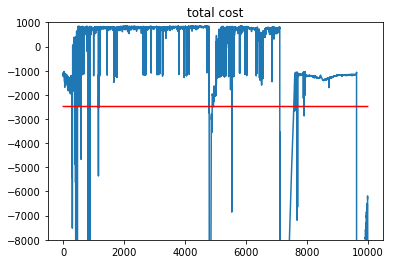

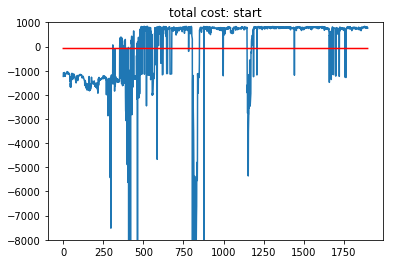

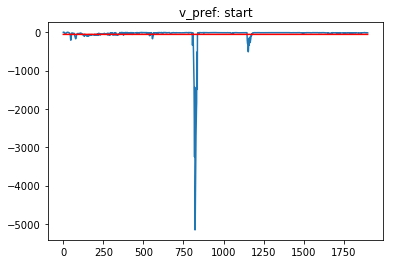

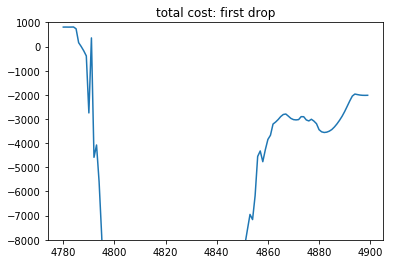

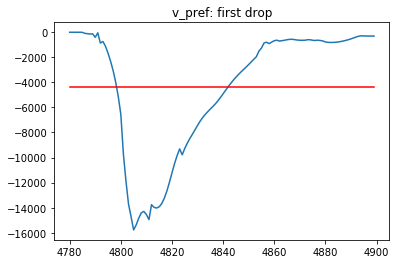

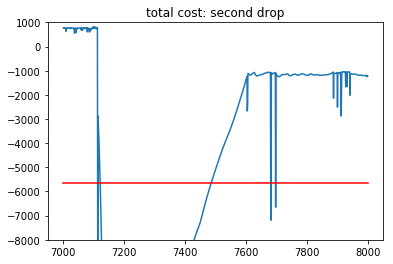

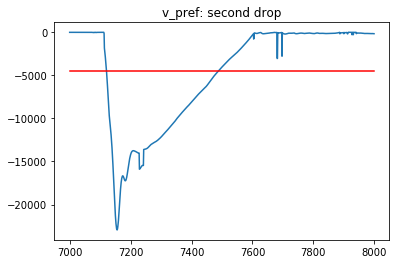

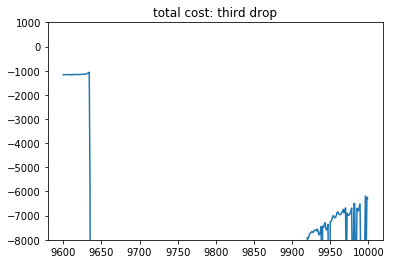

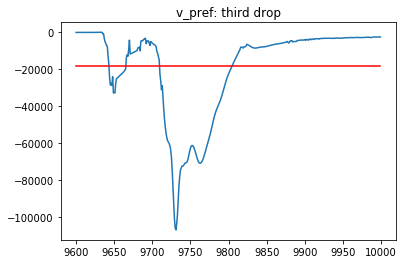

In [98]:
def plot_avg_1d(vec, title=None, xlabel=None, ylabel=None, save=False, ylim=None, begin=0):
    record = np.array(vec)
    if len(record.shape) is not 1:
        print 'vec should be 1D array [e0, e1, ...]'
        return
    if ylim is not None:
        axes = plt.gca()
        axes.set_ylim(ylim)
    mu = record.mean(axis=0)
    plt.plot(np.array(range(record.shape[0]))+begin, record)
    plt.plot(np.array(range(record.shape[0]))+begin, mu*np.ones(record.shape[0]), color='red')
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel, rotation=45)
    if save:
        plt.savefig('{}.png'.format(title))      
    plt.show()

def plot_avg_2d(vec, title=None, xlabel=None, ylabel=None, save=False):
    record = np.array(vec)
    if len(record.shape) is not 2:
        print 'vec should be 2D array [[seq0], [seq1], ...]'
        return
    mu = record.mean(axis=0)
    sigma = record.std(axis=0)
    lower_bound = mu-sigma
    upper_bound = mu+sigma
    plt.plot(xrange(mu.shape[0]), mu, color='red')
    plt.fill_between(xrange(mu.shape[0]), lower_bound, upper_bound, facecolor='blue', alpha=0.5)
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel, rotation=45)
    if save:
        plt.savefig('{}.png'.format(title))
    plt.show()

# data
n_vec_avg_cost = np.array(n_vec_avg_cost)
n_vec_total_cost = np.array(n_vec_total_cost)
cost = gym_foa.envs.FoaEnv.Cost(*np.rollaxis(n_vec_avg_cost,2))
avg_cost = cost.collision[0]+cost.goal[0]+cost.formation[0]+cost.v_pref[0]

# param
save = False

# diagram
plot_avg_1d(n_vec_total_cost[0], title='total cost', ylim=[-8000,1000], save=True)

int0 = slice(0,1900)
plot_avg_1d(n_vec_total_cost[0][int0], title='total cost: start', ylim=[-8000,1000], begin=int0.start, save=save)
plot_avg_1d(cost.v_pref[0][int0], title='v_pref: start', begin=int0.start, save=save)

int1 = slice(4780,4900)
plot_avg_1d(n_vec_total_cost[0][int1], title='total cost: first drop', ylim=[-8000,1000], begin=int1.start, save=save)
plot_avg_1d(cost.v_pref[0][int1], title='v_pref: first drop', begin=int1.start, save=save)

int2 = slice(7000,8000)
plot_avg_1d(n_vec_total_cost[0][int2], title='total cost: second drop', ylim=[-8000,1000], begin=int2.start, save=save)
plot_avg_1d(cost.v_pref[0][int2], title='v_pref: second drop', begin=int2.start, save=save)

int3 = slice(9600,10000)
plot_avg_1d(n_vec_total_cost[0][int3], title='total cost: third drop', ylim=[-8000,1000], begin=int3.start, save=save)
plot_avg_1d(cost.v_pref[0][int3], title='v_pref: third drop', begin=int3.start, save=save)            
            

In [54]:
#torch.save(actor.state_dict(), 'actor.param')
#torch.save(critic.state_dict(), 'critic.param')

#from gym import wrappers

#env = wrappers.Monitor(env, 'exp', force=True)


actor = Actor()

actor = torch.load('actor0.pt')
            
for n in xrange(1):
    o = env.reset()
    actor = Actor().cuda()
    for t in xrange(MAX_STEP):
        print 'n:{}, t:{}'.format(n, t)
        env.render()
        a0 = choose_action(o[:N_STATES/N_UAVS], actor)
        #a1 = choose_action(o[N_STATES/N_UAVS:-N_STATES/N_UAVS], actor)
        #a2 = choose_action(o[-N_STATES/N_UAVS:], actor)
        #a = np.hstack([a0, a1, a2])
        
        print a0
        
        o_, r, done, info = env.step(a0)
    
        o = o_
        if done:
            break

[2017-10-02 10:13:15,362] Starting new video recorder writing to /home/linjt/foa/total_cost/openaigym.video.0.17782.video010000.mp4



 0.0049
 0.3520
 0.2389
-0.2096
-0.0965
-0.1469
-0.1138
 0.2946
-0.1953
[torch.FloatTensor of size 9]


 0.7399
 0.0231
-0.1492
-0.5828
-0.0831
 0.6275
 0.3405
 0.8336
 0.2489
[torch.cuda.FloatTensor of size 9 (GPU 0)]

n:0, t:0
[ 0.58178931 -0.64757133]
n:0, t:1
[ 0.41625622 -0.0412141 ]
n:0, t:2
[ 0.40152949 -0.05188049]
n:0, t:3
[ 0.3768146  -0.04571682]
n:0, t:4
[ 0.35293692 -0.03704762]
n:0, t:5
[ 0.33084947 -0.02914675]
n:0, t:6
[ 0.31682843 -0.02340169]
n:0, t:7
[ 0.31059319 -0.0185623 ]
n:0, t:8
[ 0.30542314 -0.01386533]
n:0, t:9
[ 0.30428684 -0.01331225]
n:0, t:10
[ 0.30261526 -0.01384161]
n:0, t:11
[ 0.30214629 -0.01438845]
n:0, t:12
[ 0.30086541 -0.01824794]
n:0, t:13
[ 0.30128843 -0.02189668]
n:0, t:14
[ 0.30347696 -0.02392984]
n:0, t:15
[ 0.30585411 -0.02362125]
n:0, t:16
[ 0.30783179 -0.0237852 ]
n:0, t:17
[ 0.31190801 -0.02718499]
n:0, t:18
[ 0.37823272 -0.05074175]
n:0, t:19
[ 0.36056635 -0.03564465]
n:0, t:20
[ 0.34637523 -0.0189302 ]
n:0, t:21
[ 0.33369434 -0.0025803

In [96]:
import pickle

# Saving the objects:
with open('total_cost.pickle', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump(n_vec_total_cost, f)

## Getting back the objects:
#with open('objs.pickle') as f:  # Python 3: open(..., 'rb')
#    k = pickle.load(f)
    
#print cost

In [71]:
x = np.array(range(10)).reshape(2,-1)
s = slice(None,2)
print s.step

None
